In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput, graphs
import os
import global_settings
rng_key = jax.random.PRNGKey(0)

In [2]:
#result = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results/1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz",
    #"/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/f542d3ebd37584291a4d8e9cef5b95f7.tar.gz"
#)

# constrained
result = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results_fixed/e0518d85d27f313f2d617314dcd8386b.tar.gz",
    #"/home/gw/data/experiments/master_thesis/results_fixed/0b8d29190c9aeae7577197a46198a97d.tar.gz",
    "/home/gw/data/experiments/master_thesis/results_fixed/25a6723e6c442799e19c4876bdd06f4b.tar.gz",
)

result_gt = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results/1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz",
    #"/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df.tar.gz"
    "/home/gw/data/experiments/master_thesis/results/f542d3ebd37584291a4d8e9cef5b95f7.tar.gz"
)

experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()

normalized probabilities: [0.5665243  0.3504857  0.08298998]


In [3]:
sh_fixed = equioutput.SymmetryHelperFixed(
    parameters_template=experiment._model_transformation.init(rng_key, experiment._dataset[0][0]),
    activation_function="tanh"
)
samples_parameters_mirrored = result_gt.samples["parameters"]
samples_parameters_mirrored = sh_fixed.remove_tanh_symmetries(samples_parameters_mirrored, bias=True)
samples_parameters_mirrored = sh_fixed.remove_permutation_symmetries(samples_parameters_mirrored, bias=True)

samples_parameters_fs.shape (1274, 13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.71it/s]


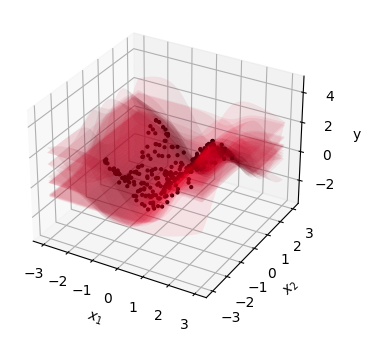

In [4]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.72it/s]


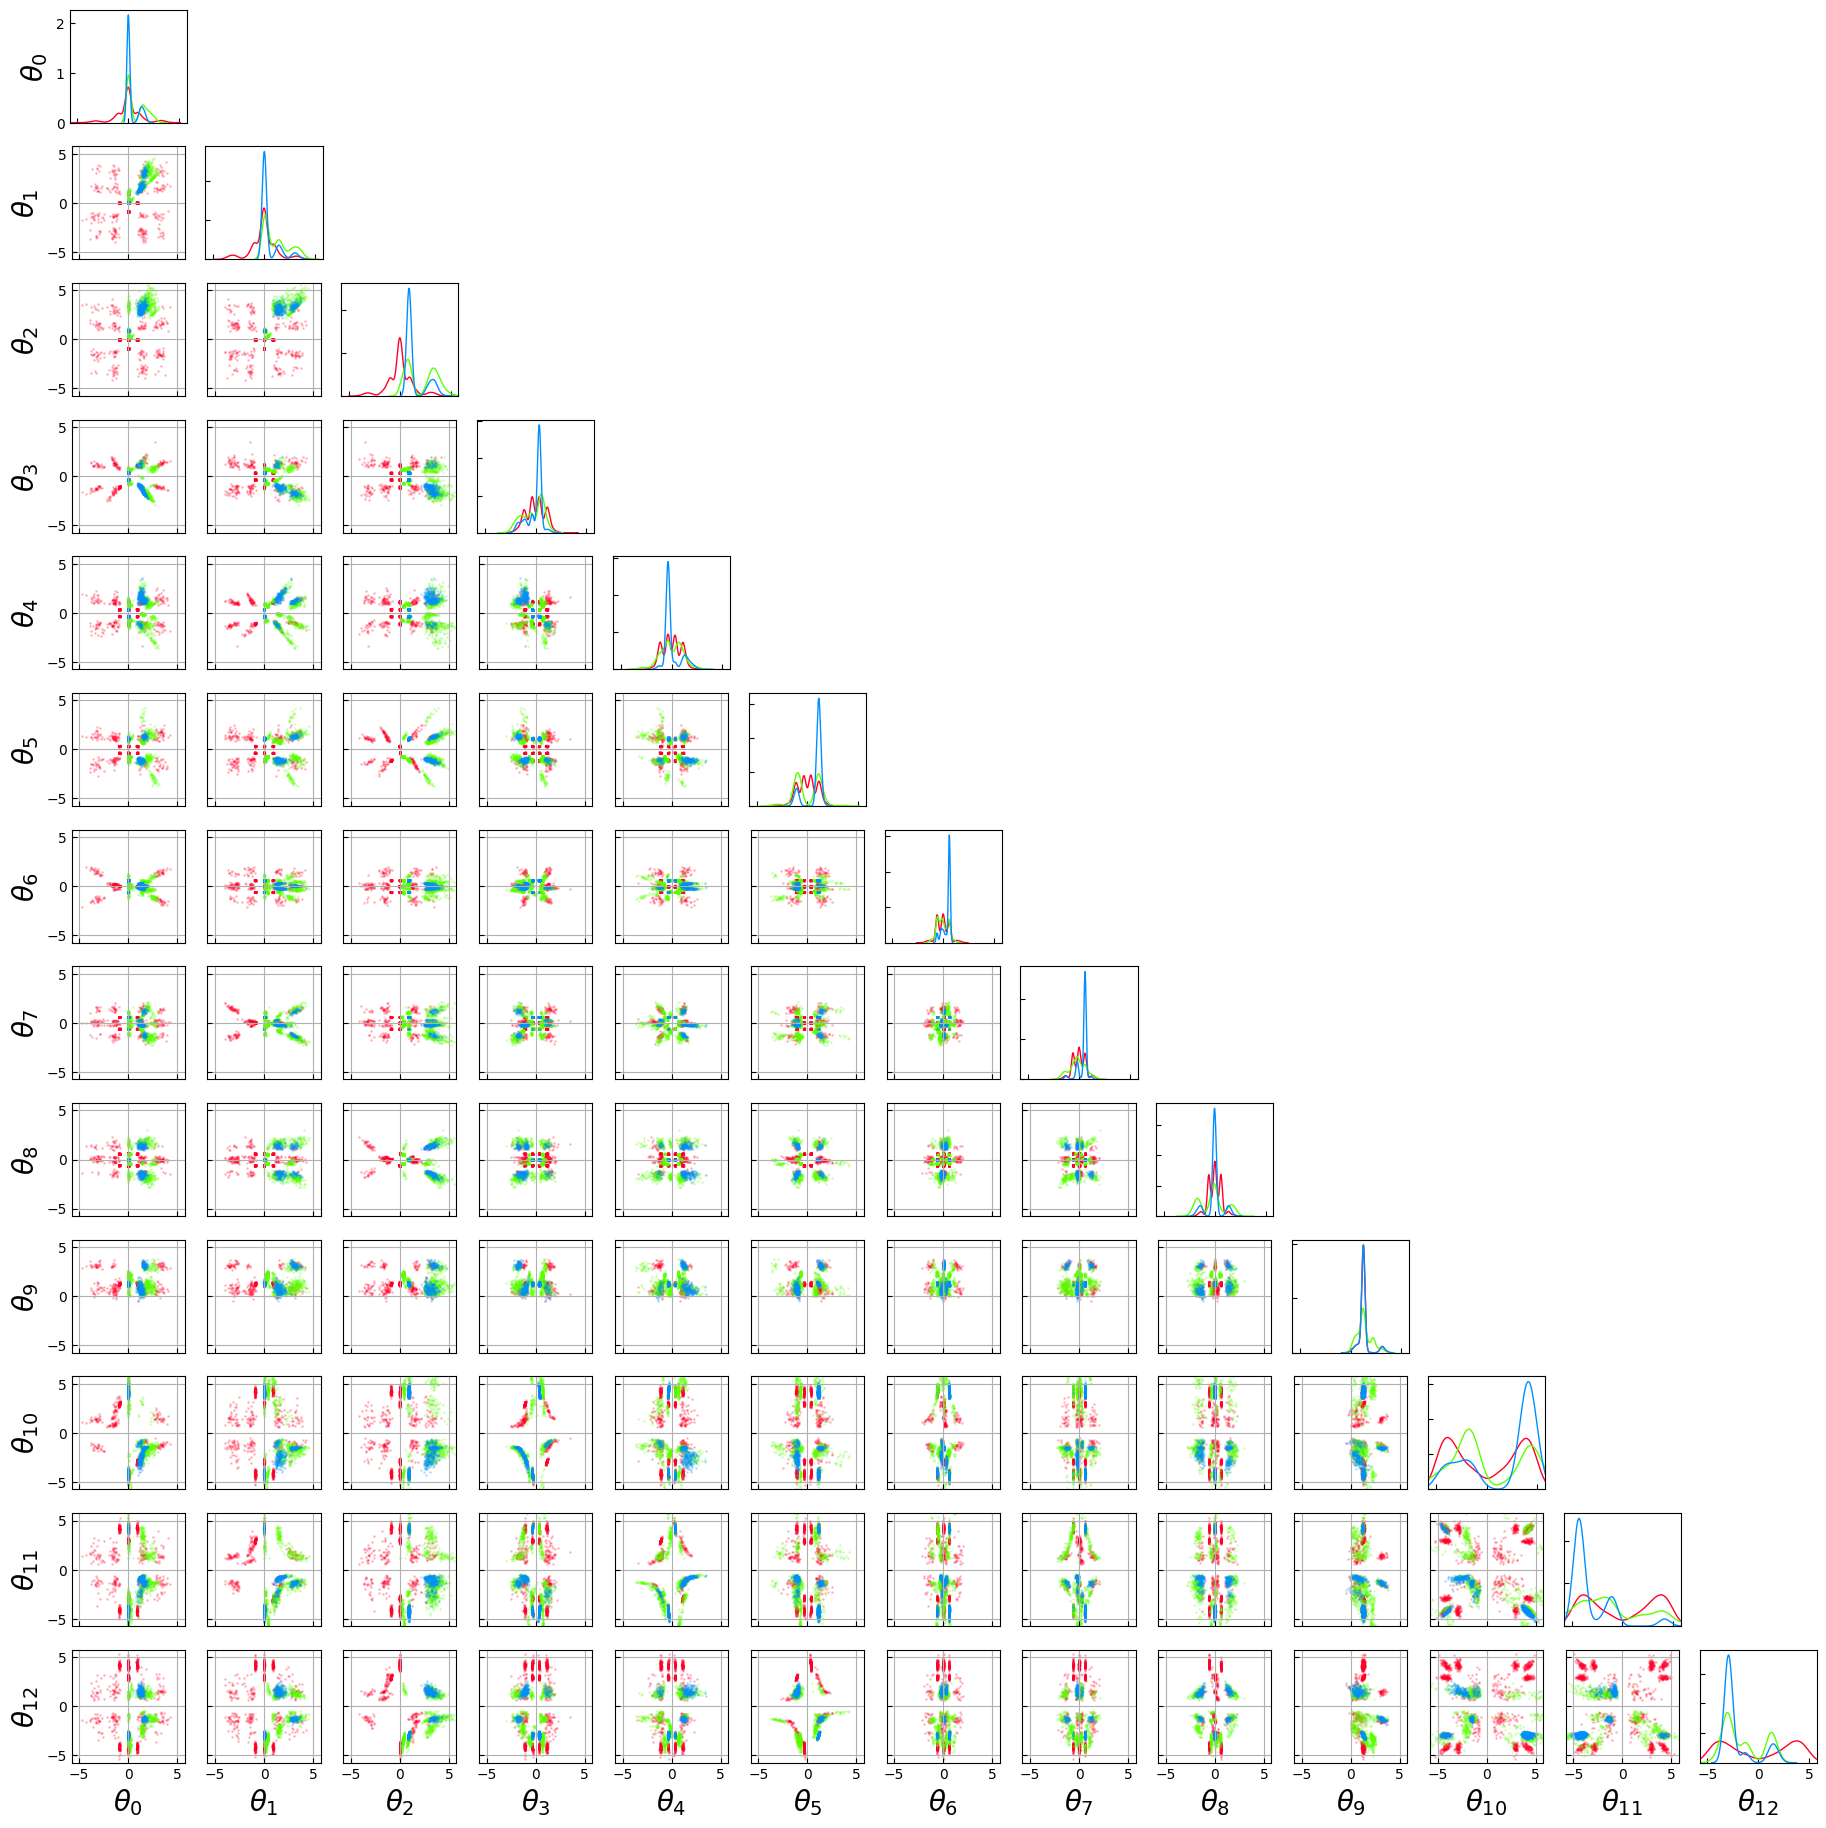

In [5]:
import matplotlib
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters_posterior = samples_parameters_fs
samples_parameters_posterior_gt = result_gt.samples["parameters"]
#if samples_parameters_posterior.shape[-1] > 10:
#    samples_parameters_posterior = samples_parameters_posterior[:, jax.random.permutation(rng_key_, jnp.arange(samples_parameters_fs.shape[-1]))[:10]]

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[samples_parameters_posterior_gt, samples_parameters_posterior, samples_parameters_mirrored]
)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from data import standardize

samples_gt = standardize(samples_parameters_posterior_gt)
samples_online = standardize(samples_parameters_posterior)
samples_posthoc = standardize(samples_parameters_mirrored)

In [7]:
def get_knn_sc_eigenvalues(samples, n=256):
    a = graphs.knn_graph(nodes=samples, k=10)
    d = graphs.degree_matrix(a)
    l = graphs.laplacian(a=a, d=d, normalized=True)
    eigenvalues, eigenvectors = graphs.spectrum(l=l, k=n, normalized=False)
    return eigenvalues

In [8]:
lambdas_gt = get_knn_sc_eigenvalues(samples_gt)
lambdas_online = get_knn_sc_eigenvalues(samples_online)
lambdas_posthoc = get_knn_sc_eigenvalues(samples_posthoc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:03<00:00, 360.41it/s]


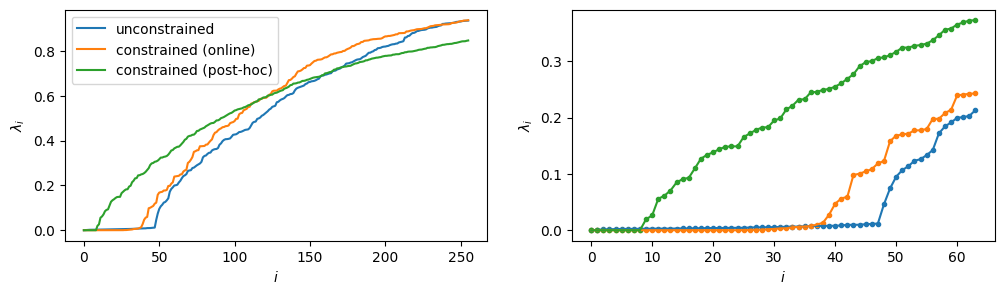

In [9]:
amount_1 = 256
amount_2 = 64
lambdas_indices_1 = np.arange(len(lambdas_gt[:amount_1]))
lambdas_indices_2 = np.arange(len(lambdas_gt[:amount_2]))
s=9
cm = matplotlib.cm.get_cmap("gist_rainbow")

figure = plt.figure(figsize=(12, 3))
ax1 = figure.add_subplot(1, 2, 1)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$\lambda_i$")
ax1.plot(lambdas_indices_1, lambdas_gt[:amount_1], label="unconstrained")
ax1.plot(lambdas_indices_1, lambdas_online[:amount_1], label="constrained (online)")
ax1.plot(lambdas_indices_1, lambdas_posthoc[:amount_1], label="constrained (post-hoc)")

ax2 = figure.add_subplot(1, 2, 2)
ax2.set_xlabel(r"$i$")
ax2.set_ylabel(r"$\lambda_i$")
ax2.scatter(lambdas_indices_2, lambdas_gt[:amount_2], marker="o", s=s)
ax2.plot(lambdas_indices_2, lambdas_gt[:amount_2])
ax2.scatter(lambdas_indices_2, lambdas_online[:amount_2], marker="o", s=s)
ax2.plot(lambdas_indices_2, lambdas_online[:amount_2])
ax2.scatter(lambdas_indices_2, lambdas_posthoc[:amount_2], marker="o", s=s)
ax2.plot(lambdas_indices_2, lambdas_posthoc[:amount_2])
ax1.legend()

figure

In [10]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "eigengaps.png"), bbox_inches="tight", dpi=192, transparent=True)